# Variational AutoEncoder

(https://twitter.com/fchollet)<br>
Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup


In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

## Строим слой семплирования sampling layer


In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Строим энкодер encoder


In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Строим свой decoder


In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## Создаем класс модель по `Model` с особым шагом *обучения* `train_step`


In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

## Учим VAE


In [6]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=10, batch_size=128)

Epoch 1/10
547/547 [==============================] - 11s 10ms/step - loss: 316.4981 - reconstruction_loss: 310.9058 - kl_loss: 5.5923
Epoch 2/10
547/547 [==============================] - 5s 10ms/step - loss: 275.5554 - reconstruction_loss: 270.9955 - kl_loss: 4.5598
Epoch 3/10
547/547 [==============================] - 5s 10ms/step - loss: 270.1848 - reconstruction_loss: 266.1273 - kl_loss: 4.0575
Epoch 4/10
547/547 [==============================] - 5s 10ms/step - loss: 267.7321 - reconstruction_loss: 263.8626 - kl_loss: 3.8695
Epoch 5/10
547/547 [==============================] - 5s 10ms/step - loss: 265.9749 - reconstruction_loss: 262.1885 - kl_loss: 3.7864
Epoch 6/10
547/547 [==============================] - 5s 10ms/step - loss: 264.9969 - reconstruction_loss: 261.2628 - kl_loss: 3.7341
Epoch 7/10
547/547 [==============================] - 5s 10ms/step - loss: 263.7419 - reconstruction_loss: 260.0285 - kl_loss: 3.7135
Epoch 8/10
547/547 [==============================] - 6s 10ms

In [7]:
vae.fit(mnist_digits, epochs=50, batch_size=128)

Epoch 1/50
547/547 [==============================] - 6s 11ms/step - loss: 261.4033 - reconstruction_loss: 257.7209 - kl_loss: 3.6823
Epoch 2/50
547/547 [==============================] - 6s 11ms/step - loss: 260.9207 - reconstruction_loss: 257.2304 - kl_loss: 3.6903
Epoch 3/50
547/547 [==============================] - 6s 11ms/step - loss: 260.5578 - reconstruction_loss: 256.8561 - kl_loss: 3.7016
Epoch 4/50
547/547 [==============================] - 6s 11ms/step - loss: 260.1530 - reconstruction_loss: 256.4472 - kl_loss: 3.7058
Epoch 5/50
547/547 [==============================] - 6s 10ms/step - loss: 259.7337 - reconstruction_loss: 256.0185 - kl_loss: 3.7152
Epoch 6/50
547/547 [==============================] - 6s 10ms/step - loss: 259.5907 - reconstruction_loss: 255.8705 - kl_loss: 3.7202
Epoch 7/50
547/547 [==============================] - 6s 10ms/step - loss: 259.1717 - reconstruction_loss: 255.4309 - kl_loss: 3.7408
Epoch 8/50
547/547 [==============================] - 6s 10ms/

## Результат предсказания для цифры


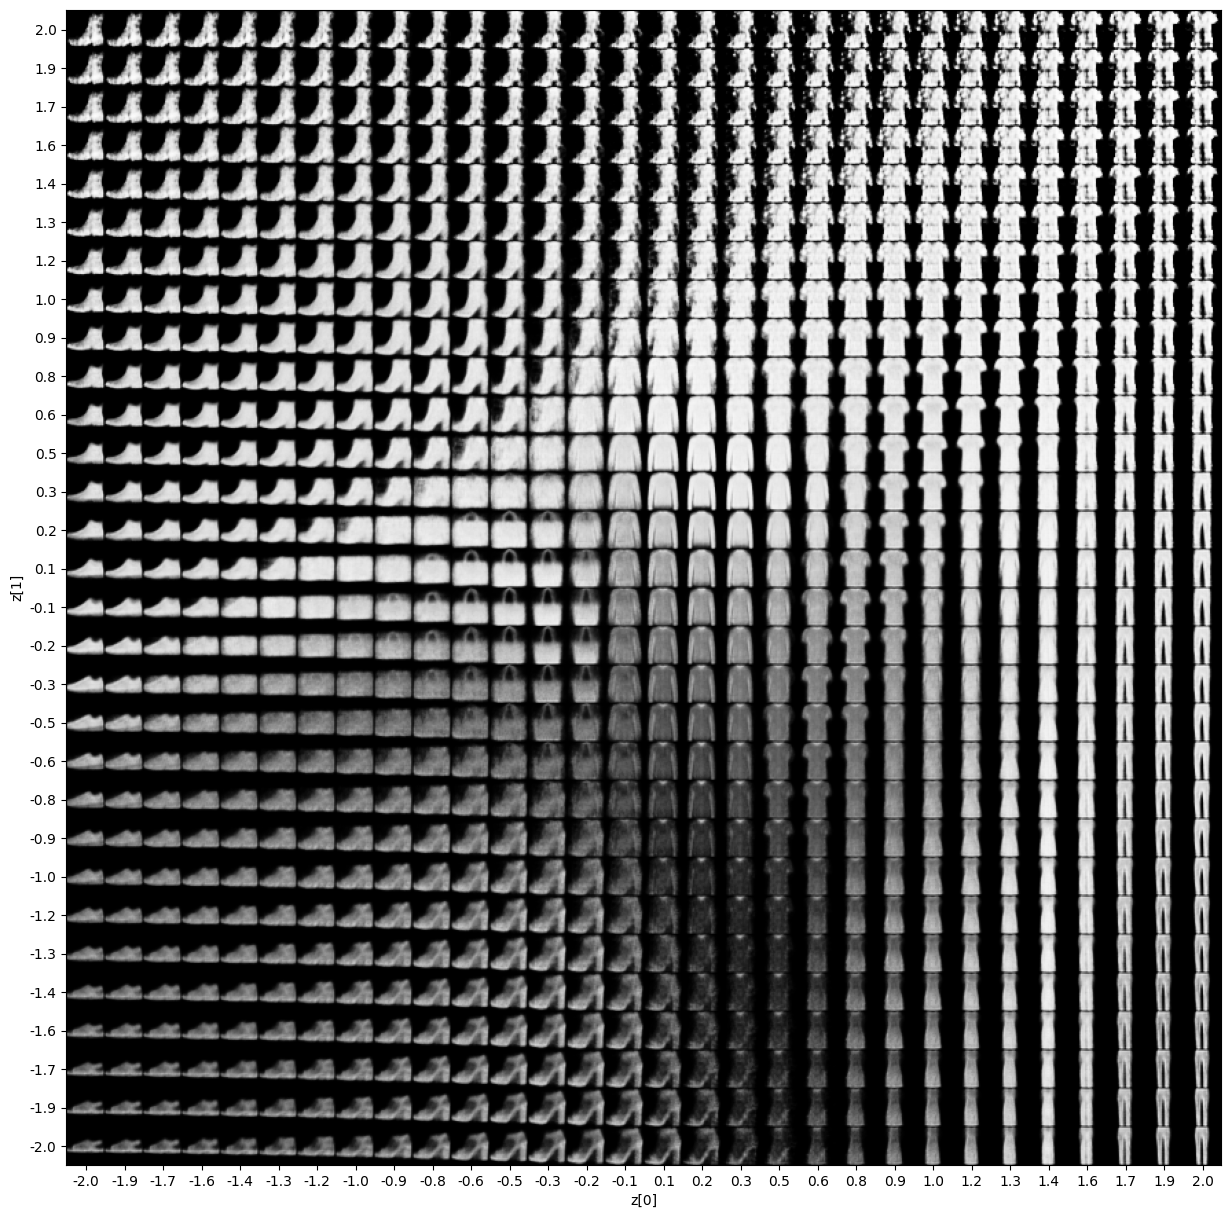

In [8]:
import matplotlib.pyplot as plt


def plot_latent(encoder, decoder):
    # display a n*n 2D manifold of digits
    n = 30
    digit_size = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range 
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

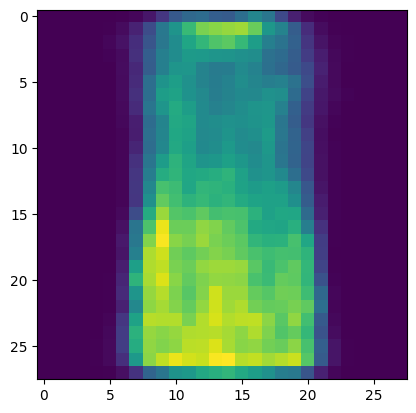

In [9]:
x_decoded = decoder.predict([[0.8,-1.1]])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

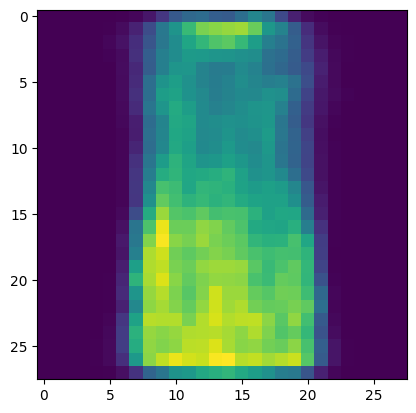

In [10]:
plt.imshow(x_decoded[0,:,:,0] )
plt.show()

## Посмотрим на кластеры в скрытом пространстве для цифр


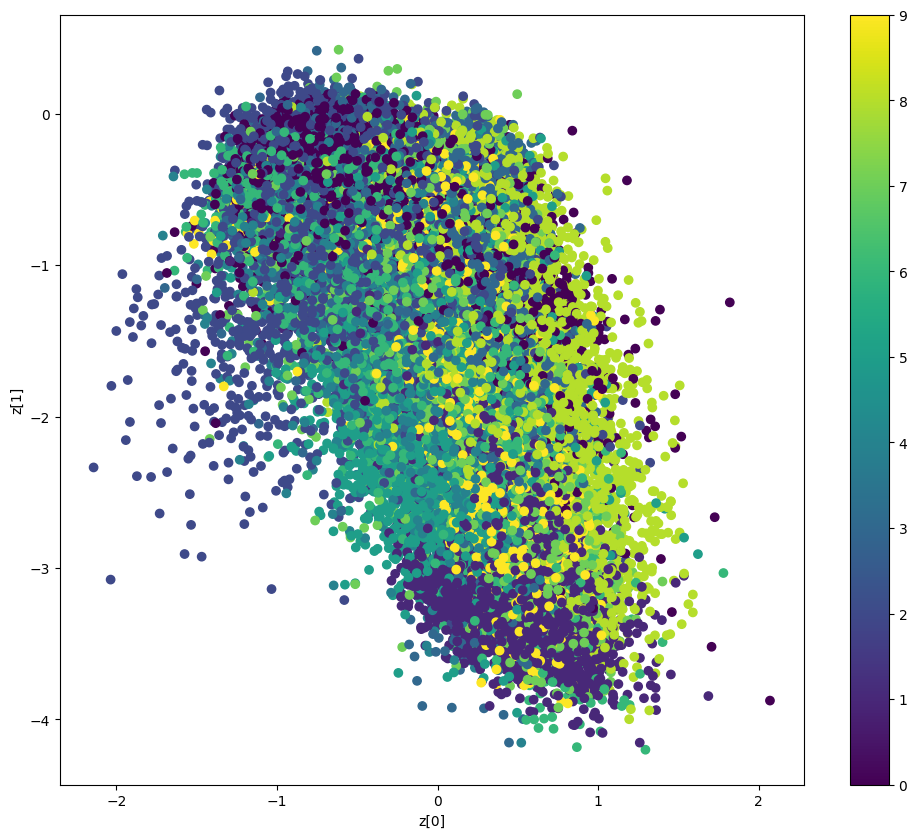

In [11]:
def plot_label_clusters(encoder, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(encoder, x_train, y_train)

Построим немного примеров генерации цифр:

для этого не нужен энкодер
работа этой модели требует:
- выбрать случайные значения для точки скрытого пространства (2 координаты (среднее и логарифм от дисперсиии) - для построения в n (в нашем случае 28х28) координаты нового образца )
- подать их в декодер
- визуализировать результат

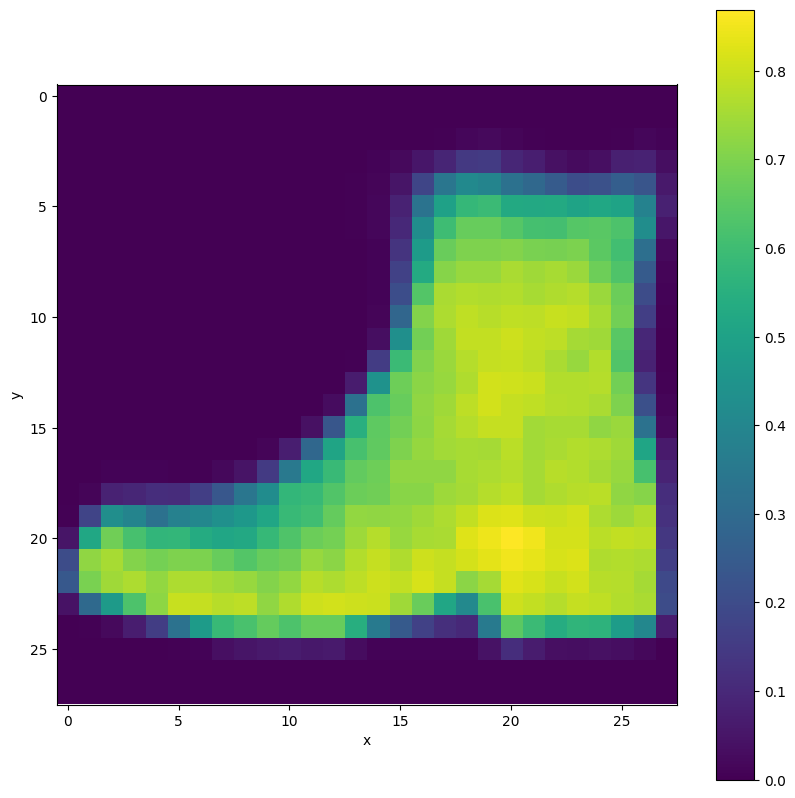

In [12]:
def plot_digit_from_decoder(decoder, z, digit_size):
    # display a 2D plot of the digit classes in the latent space
    
    data = np.array([[z[0], z[1]]])
    digit = decoder.predict(data)
    digit = digit.reshape(digit_size, digit_size)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(digit)
    plt.colorbar()
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

plot_digit_from_decoder(decoder, [-1.5,1.], 28)

In [13]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
def make_coders(start_n, latent_dim, shape=(28, 28, 1), kernel_size=3):
    # encoder
    encoder_inputs = keras.Input(shape=shape)
    x = layers.Conv2D(start_n, kernel_size, activation="relu", strides=2, padding="same")(encoder_inputs)
    x = layers.Conv2D(start_n*2, kernel_size, activation="relu", strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(int(start_n/2), activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    # decoder
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * start_n*4, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, start_n*4))(x)
    x = layers.Conv2DTranspose(start_n*4, kernel_size, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(int(start_n/2), kernel_size, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, kernel_size, activation="sigmoid", padding="same")(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    return encoder, decoder

In [15]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, balance_loss=0.5, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.balance_loss = balance_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = 2 * (reconstruction_loss * self.balance_loss + kl_loss * (1 - self.balance_loss))
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

## Учим VAE


In [16]:
models = []

In [17]:
latent_dims = [3, 5, 7, 10]
starts = [32, 64, 128]

In [18]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
mnist_data = np.concatenate([x_train, x_test], axis=0)
mnist_data = np.expand_dims(mnist_data, -1).astype("float32") / 255

In [19]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=0.0005,
    patience=3,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

In [20]:
for latent_dim in latent_dims:
    for start_n in starts:
        name = f'l_dim {latent_dim}, start_n {start_n}'
        print(name)
        encoder, decoder = make_coders(start_n, latent_dim)
        vae = VAE(encoder, decoder)
        vae.compile(optimizer=keras.optimizers.Adam())
        history = vae.fit(
            mnist_data, 
            epochs=1000, 
            batch_size=128,
            callbacks=[early_stopping],
            verbose=0
        )            
        models.append({
            'name': name,
            'model': vae,
            'latent_dim': latent_dim,
            'encoder': encoder,
            'decoder': decoder,
            'history': history,
            "reconstruction_loss": history.history['reconstruction_loss'][-1],
            "kl_loss": history.history['kl_loss'][-1],
            "loss": history.history['loss'][-1],
        })
        print(f'reconstruction_loss {models[-1]["reconstruction_loss"]}, kl_loss {models[-1]["kl_loss"]}, loss {models[-1]["loss"]}\n')

l_dim 3, start_n 32
reconstruction_loss 252.3948211669922, kl_loss 3.9523322582244873, loss 256.34716796875

l_dim 3, start_n 64
reconstruction_loss 257.19830322265625, kl_loss 4.211984157562256, loss 261.4102783203125

l_dim 3, start_n 128
reconstruction_loss 232.69427490234375, kl_loss 3.383394241333008, loss 236.07766723632812

l_dim 5, start_n 32
reconstruction_loss 229.94273376464844, kl_loss 3.8295114040374756, loss 233.77224731445312

l_dim 5, start_n 64
reconstruction_loss 232.04010009765625, kl_loss 3.2757961750030518, loss 235.31590270996094

l_dim 5, start_n 128
reconstruction_loss 227.6341094970703, kl_loss 3.3554069995880127, loss 230.98951721191406

l_dim 7, start_n 32
reconstruction_loss 222.31021118164062, kl_loss 3.4838082790374756, loss 225.7940216064453

l_dim 7, start_n 64
reconstruction_loss 219.62254333496094, kl_loss 3.561873197555542, loss 223.18441772460938

l_dim 7, start_n 128
reconstruction_loss 222.41085815429688, kl_loss 3.261896848678589, loss 225.6727600

In [32]:
pd.DataFrame(models).drop(['model', 'history', 'encoder', 'decoder'],axis=1)

,name,latent_dim,reconstruction_loss,kl_loss,loss
0,"l_dim 3, start_n 32",3,252.394821,3.952332,256.347168
1,"l_dim 3, start_n 64",3,257.198303,4.211984,261.410278
2,"l_dim 3, start_n 128",3,232.694275,3.383394,236.077667
3,"l_dim 5, start_n 32",5,229.942734,3.829511,233.772247
4,"l_dim 5, start_n 64",5,232.040100,3.275796,235.315903
5,"l_dim 5, start_n 128",5,227.634109,3.355407,230.989517
6,"l_dim 7, start_n 32",7,222.310211,3.483808,225.794022
7,"l_dim 7, start_n 64",7,219.622543,3.561873,223.184418
8,"l_dim 7, start_n 128",7,222.410858,3.261897,225.672760
9,"l_dim 10, start_n 32",10,230.970871,3.077628,234.048492


In [42]:
results = pd.DataFrame(models)
results = results.sort_values(by=['loss'], ascending=True, ignore_index=True)
results.drop(['model', 'history', 'encoder', 'decoder'],axis=1)[:]

,name,latent_dim,reconstruction_loss,kl_loss,loss
0,"l_dim 7, start_n 64",7,219.622543,3.561873,223.184418
1,"l_dim 10, start_n 128",10,220.523529,3.237525,223.761047
2,"l_dim 7, start_n 128",7,222.410858,3.261897,225.672760
3,"l_dim 7, start_n 32",7,222.310211,3.483808,225.794022
4,"l_dim 10, start_n 64",10,224.476700,3.330726,227.807419
5,"l_dim 5, start_n 128",5,227.634109,3.355407,230.989517
6,"l_dim 5, start_n 32",5,229.942734,3.829511,233.772247
7,"l_dim 10, start_n 32",10,230.970871,3.077628,234.048492
8,"l_dim 5, start_n 64",5,232.040100,3.275796,235.315903
9,"l_dim 3, start_n 128",3,232.694275,3.383394,236.077667


## Результат предсказания для цифры


In [57]:
latent_sample = [random.gauss(0, 1) for _ in range(results.loc[0]['latent_dim'])]
latent_sample

[-0.8436132872009218,
 0.5571992620049493,
 -0.9028663514291931,
 0.08246496218505212,
 -0.9355372998001766,
 -0.22908292022121746,
 1.2421491907598192]

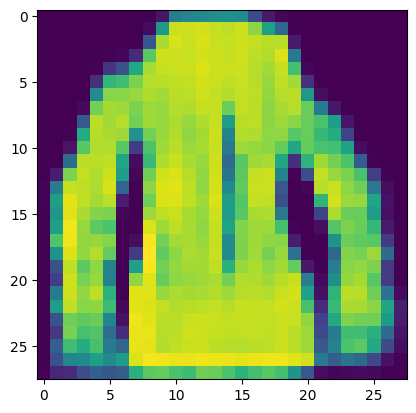

In [58]:
x_decoded = results.loc[0]['decoder'].predict([latent_sample])
plt.imshow(x_decoded[0,:,:,0] )
plt.show()